<a href="https://colab.research.google.com/github/danon6868/BI-ml-course/blob/main/lecture_8_neural_networks_part2/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [2]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [35]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:**

Больше батч -быстрее учимся. Более плавный спуск получается, меньше шума и пересчёта коэффициентов.

Посмотрим на какую-нибудь картинку:

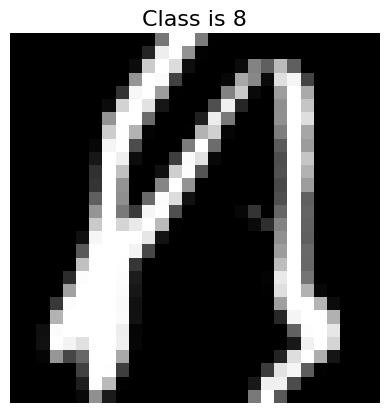

In [4]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





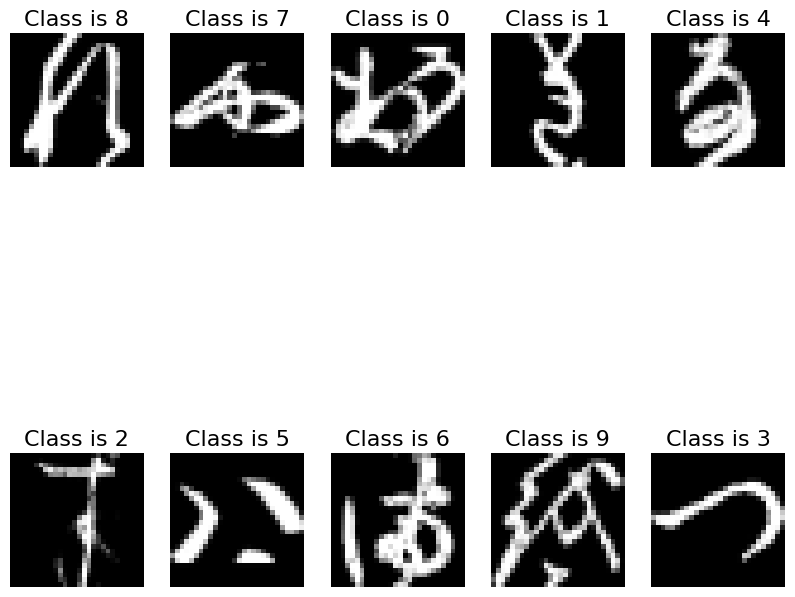

In [10]:
fig, axs = plt.subplots(2, 5, figsize=(10, 10))
unique_class = set()
for ax in axs.flat:
  for mark in trainset:
    if mark[1] not in unique_class:
      unique_class.add(mark[1])
      ax.set_title(f"Class is {mark[1]}", fontsize=16)
      ax.imshow(mark[0].view(28, 28).numpy(), cmap="gray")
      ax.axis("off")
      break

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.
 
https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [12]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        #Слойчики:
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        #Активация:
        self.activation = nn.ReLU()

    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        #Мне из лекции показалось что не надо активацию после последнего слоя
        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

Всего параметров будет:

In [15]:
784 * 256 + 256 + 256 * 128 + 128 + 128 * 10 + 10 

235146

### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [33]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    
    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [17]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?
Спасибо Д

In [18]:
%%time
n_epochs = 10
loss_history = []
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")


Epoch=1 loss=0.9084
Epoch=2 loss=0.4448
Epoch=3 loss=0.3547
Epoch=4 loss=0.2957
Epoch=5 loss=0.2534
Epoch=6 loss=0.2189
Epoch=7 loss=0.1909
Epoch=8 loss=0.1660
Epoch=9 loss=0.1458
Epoch=10 loss=0.1292
CPU times: user 25.4 s, sys: 1.71 s, total: 27.1 s
Wall time: 1min 42s


In [19]:
get_accuracy(fc_net, testloader)

0.879

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [21]:
mean = torch.mean(trainset.data.to(torch.float32))/torch.max(trainset.data.to(torch.float32)) ## calculate mean
std = torch.std(trainset.data.to(torch.float32))/torch.max(trainset.data.to(torch.float32)) ## calculate std
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm 
testset.transform = transform_with_norm

tensor(0.1918) tensor(0.3483)


In [22]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [23]:
n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
        optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
        outputs = fc_net(images) # делаем предсказания
        loss = loss_function(outputs, labels) # считаем лосс
        loss.backward() # считаем градиенты
        optimizer.step() # делаем шаг градиентного спуска

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=0.6988
Epoch=2 loss=0.3076
Epoch=3 loss=0.2259
Epoch=4 loss=0.1758
Epoch=5 loss=0.1407
Epoch=6 loss=0.1143
Epoch=7 loss=0.0934
Epoch=8 loss=0.0778
Epoch=9 loss=0.0625
Epoch=10 loss=0.0512


In [24]:
get_accuracy(fc_net, testloader)

0.8987

Как изменилась `accuracy` после нормализации?

Повысилась, значит нормализация - полезная штука)

### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [31]:
class FCNet(nn.Module):
    def __init__(self, activation):
        super().__init__() 
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        #активация
        self.activation = activation        

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)

        return x

In [37]:
n_epochs = 10

## YOUR CODE HERE
activation_list = [nn.GELU(), nn.Sigmoid(), nn.Tanh()]
for activation in activation_list:
  print(f'Activation function is {activation}')
  fc_net = FCNet(activation = activation)
  loss_function = nn.CrossEntropyLoss()
  lr = 0.001
  optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
  loss_history = []

  for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
      optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
      outputs = fc_net(images) # делаем предсказания
      loss = loss_function(outputs, labels) # считаем лосс
      loss.backward() # считаем градиенты
      optimizer.step() # делаем шаг градиентного спуска

      epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")  
  print(f"accuracy: {get_accuracy(fc_net, testloader)}")
  print()

Activation function is GELU(approximate='none')
Epoch=1 loss=0.6640
Epoch=2 loss=0.2832
Epoch=3 loss=0.2054
Epoch=4 loss=0.1572
Epoch=5 loss=0.1238
Epoch=6 loss=0.0985
Epoch=7 loss=0.0805
Epoch=8 loss=0.0639
Epoch=9 loss=0.0511
Epoch=10 loss=0.0410
accuracy: 0.9021

Activation function is Sigmoid()
Epoch=1 loss=1.5575
Epoch=2 loss=0.7588
Epoch=3 loss=0.5434
Epoch=4 loss=0.4400
Epoch=5 loss=0.3696
Epoch=6 loss=0.3152
Epoch=7 loss=0.2726
Epoch=8 loss=0.2383
Epoch=9 loss=0.2080
Epoch=10 loss=0.1832
accuracy: 0.8564

Activation function is Tanh()
Epoch=1 loss=0.7767
Epoch=2 loss=0.3898
Epoch=3 loss=0.2637
Epoch=4 loss=0.1900
Epoch=5 loss=0.1408
Epoch=6 loss=0.1065
Epoch=7 loss=0.0799
Epoch=8 loss=0.0594
Epoch=9 loss=0.0436
Epoch=10 loss=0.0317
accuracy: 0.9018



С использованием какой функции активации удалось досчить наибольшей `accuracy`?

GELU самый классный

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [39]:
optimizers = [torch.optim.Adam, torch.optim.RMSprop, torch.optim.Adagrad]
n_epochs = 10

for opt in optimizers:
    print(f"Optimizer is {opt.__name__}")
    fc_net = FCNet(activation = nn.GELU())
    loss_function = nn.CrossEntropyLoss()
    lr = 0.001
    optimizer = opt(fc_net.parameters(), lr=3e-4)
    loss_history = []

    for epoch in range(n_epochs):
        epoch_loss = 0
        for images, labels in trainloader: 
            optimizer.zero_grad()
            outputs = fc_net(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        loss_history.append(epoch_loss/len(trainloader))
        print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")   
    print(f"accuracy: {get_accuracy(fc_net, testloader)}")
    print()

Optimizer is Adam
Epoch=1 loss=0.6586
Epoch=2 loss=0.2781
Epoch=3 loss=0.2004
Epoch=4 loss=0.1535
Epoch=5 loss=0.1207
Epoch=6 loss=0.0967
Epoch=7 loss=0.0768
Epoch=8 loss=0.0605
Epoch=9 loss=0.0474
Epoch=10 loss=0.0380
accuracy: 0.9001

Optimizer is RMSprop
Epoch=1 loss=0.4393
Epoch=2 loss=0.2419
Epoch=3 loss=0.1786
Epoch=4 loss=0.1376
Epoch=5 loss=0.1081
Epoch=6 loss=0.0855
Epoch=7 loss=0.0679
Epoch=8 loss=0.0540
Epoch=9 loss=0.0416
Epoch=10 loss=0.0329
accuracy: 0.8951

Optimizer is Adagrad
Epoch=1 loss=1.3284
Epoch=2 loss=0.8169
Epoch=3 loss=0.6929
Epoch=4 loss=0.6301
Epoch=5 loss=0.5899
Epoch=6 loss=0.5603
Epoch=7 loss=0.5375
Epoch=8 loss=0.5188
Epoch=9 loss=0.5028
Epoch=10 loss=0.4894
accuracy: 0.7225



Ну у меня получилось, что лучший Адам

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [40]:
class CustomReLU(nn.Module):     
    def __init__(self):
        super().__init__()

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x[x < 0] = 0
        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [41]:
n_epochs = 10
fc_net = FCNet(activation = nn.ReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
      optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
      outputs = fc_net(images) # делаем предсказания
      loss = loss_function(outputs, labels) # считаем лосс
      loss.backward() # считаем градиенты
      optimizer.step() # делаем шаг градиентного спуска

      epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")  
print(f"accuracy: {get_accuracy(fc_net, testloader)}")

Epoch=1 loss=0.6819
Epoch=2 loss=0.3018
Epoch=3 loss=0.2234
Epoch=4 loss=0.1747
Epoch=5 loss=0.1392
Epoch=6 loss=0.1140
Epoch=7 loss=0.0925
Epoch=8 loss=0.0765
Epoch=9 loss=0.0627
Epoch=10 loss=0.0510
accuracy: 0.8984


In [42]:
n_epochs = 10
fc_net = FCNet(activation = CustomReLU())
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: # Получаем батч тренировочных картинок
      optimizer.zero_grad() # чтобы не было как в лог регрессии, когда мы не обнуляли градиенты
      outputs = fc_net(images) # делаем предсказания
      loss = loss_function(outputs, labels) # считаем лосс
      loss.backward() # считаем градиенты
      optimizer.step() # делаем шаг градиентного спуска

      epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))
    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")  
print(f"accuracy: {get_accuracy(fc_net, testloader)}")

Epoch=1 loss=0.6834
Epoch=2 loss=0.3025
Epoch=3 loss=0.2226
Epoch=4 loss=0.1732
Epoch=5 loss=0.1397
Epoch=6 loss=0.1130
Epoch=7 loss=0.0921
Epoch=8 loss=0.0757
Epoch=9 loss=0.0621
Epoch=10 loss=0.0501
accuracy: 0.9009


Ну вроде норм, что-то похожее

### Задание 8. Генерация картинок

**3** балла

Так как вы снова работаете в командах, то придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.

Четверть короткая. времени расслабляться нет

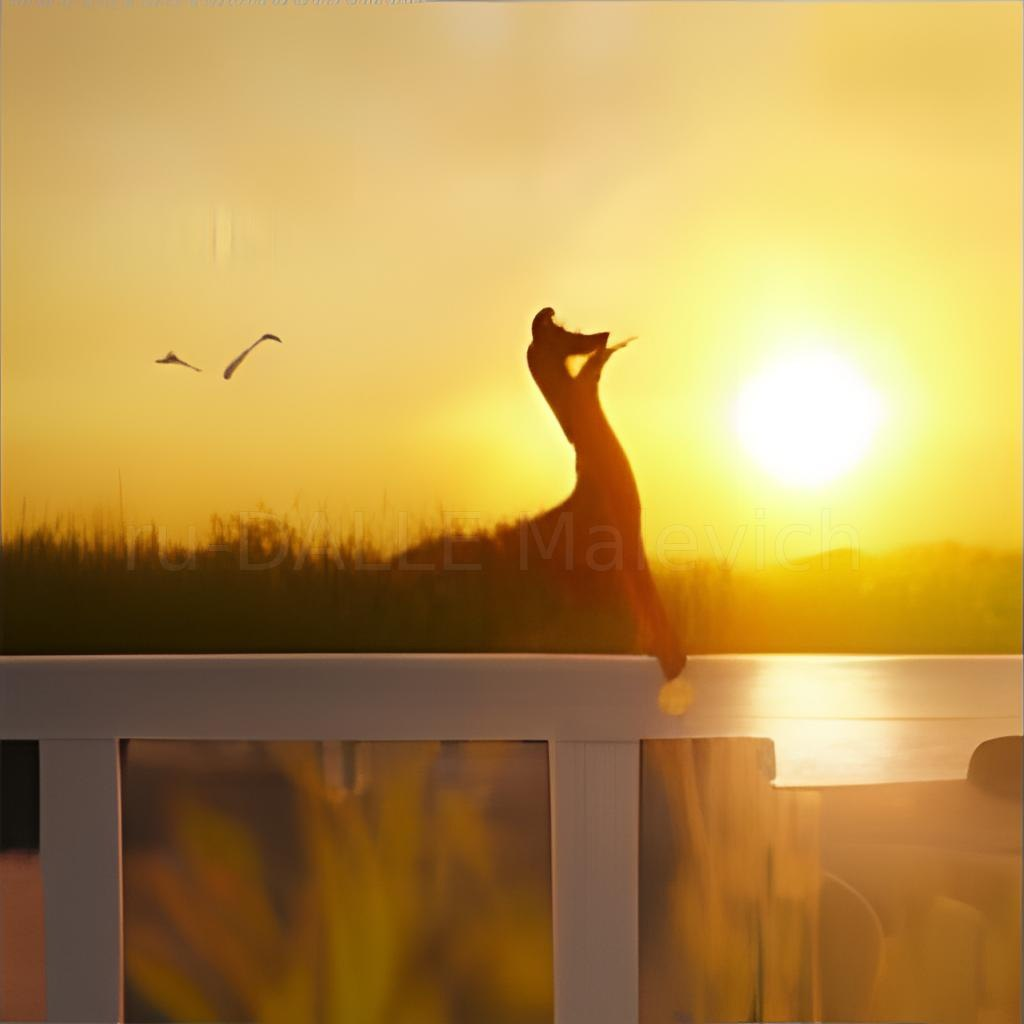

In [26]:
from IPython import display
display.Image('/content/1.jpg')

Хочу кататься на велосипеде и есть мороженку в парке

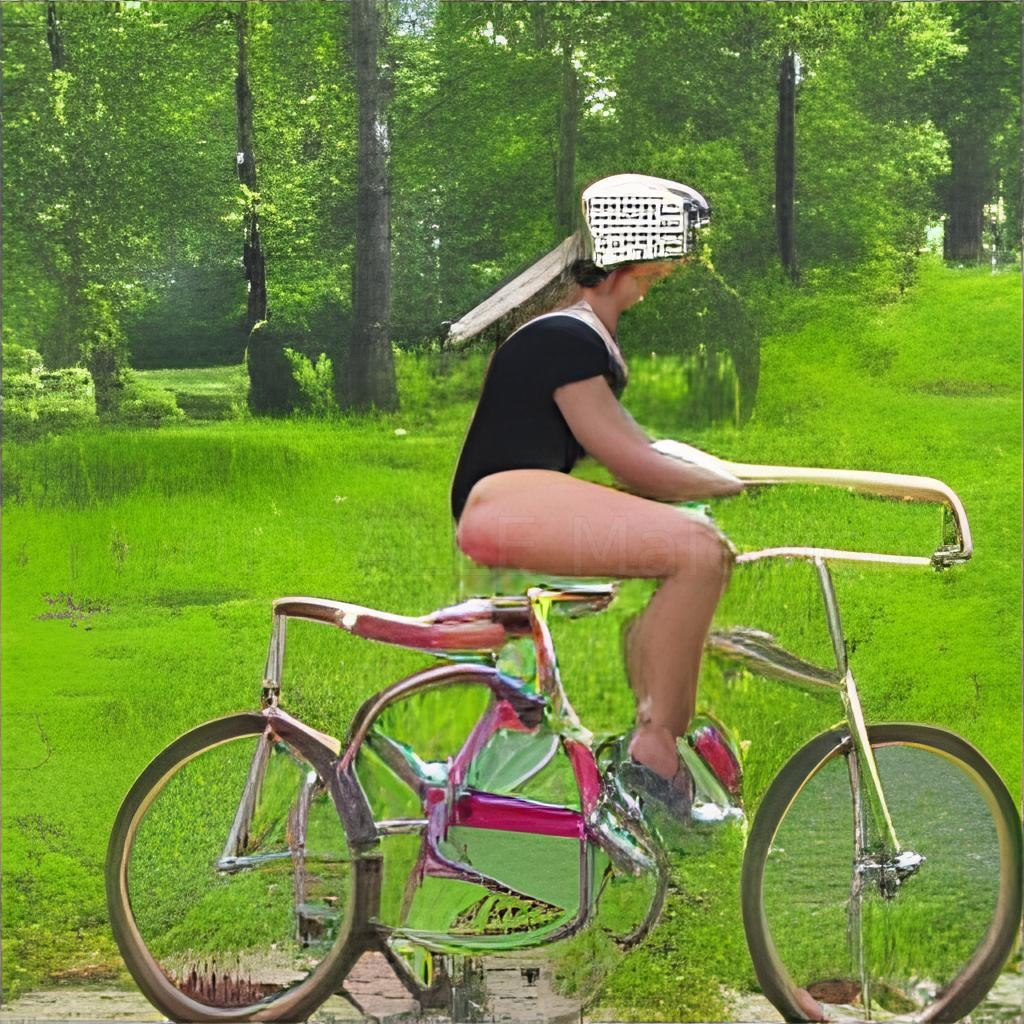

In [27]:
display.Image('/content/2.jpg')

Устала и хочу спать

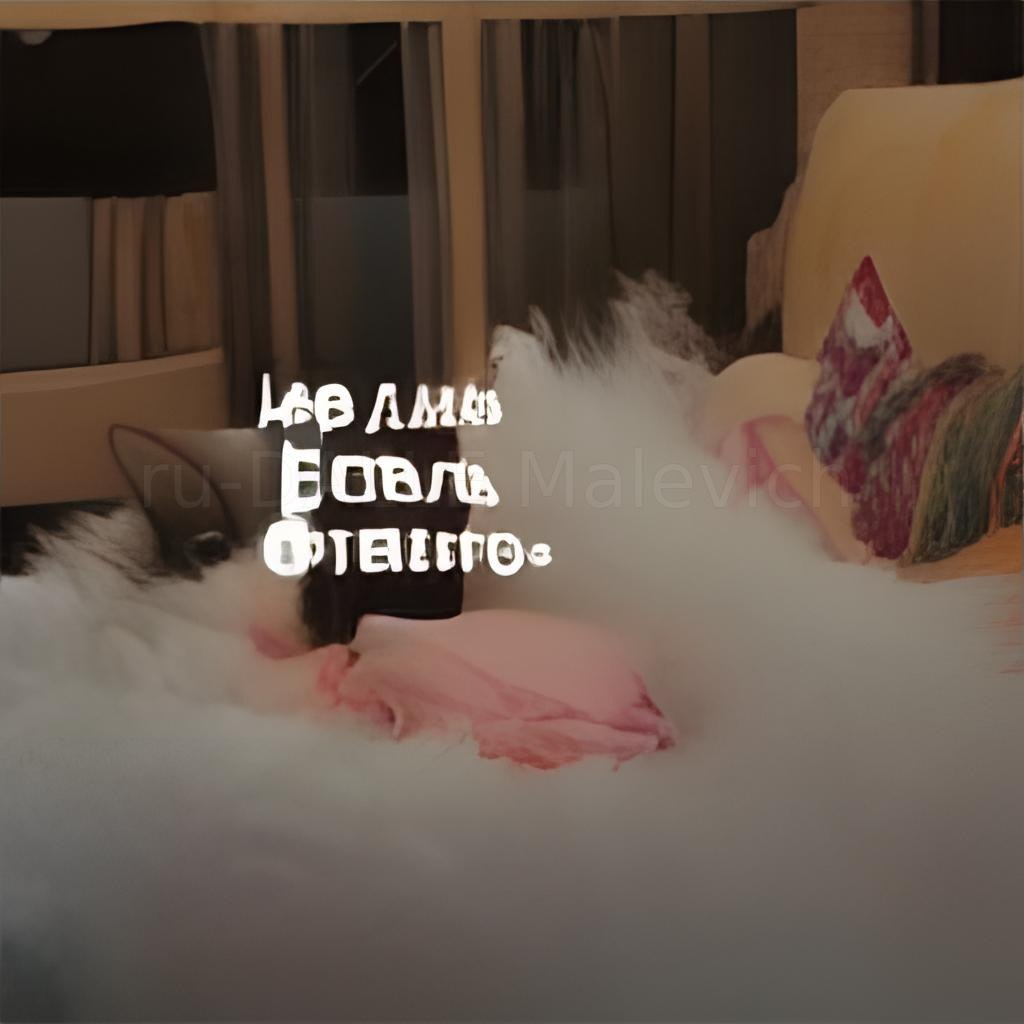

In [28]:
display.Image('/content/3.jpg')